In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [4]:
metadata_file = "C:/Users/nicyj/becode/Challenge_Mole/Data/archive/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_file)
metadata = metadata.dropna(subset=['age'])
list_of_mal = ['akiec','bcc', 'mel']
# malign - 1
# benign - 0
metadata['label'] = np.where(metadata['dx'].isin(list_of_mal),'malign', None)
metadata = metadata.replace({'label': {None: 'benign'}})
metadata["image_id"] = metadata["image_id"].apply(lambda x: x + ".jpg")
metadata.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
10010,HAM_0002867,ISIC_0033084.jpg,akiec,histo,40.0,male,abdomen,malign
10011,HAM_0002867,ISIC_0033550.jpg,akiec,histo,40.0,male,abdomen,malign
10012,HAM_0002867,ISIC_0033536.jpg,akiec,histo,40.0,male,abdomen,malign
10013,HAM_0000239,ISIC_0032854.jpg,akiec,histo,80.0,male,face,malign
10014,HAM_0003521,ISIC_0032258.jpg,mel,histo,70.0,female,back,malign


In [10]:
import os
import cv2

folder = "C:/Users/nicyj/becode/Challenge_Mole/Data/archive/HAM10000_images_part_1"

malignfolder = folder+'/malign'
malign_images = metadata[metadata['label'] == 'malign']['image_id'].to_list()

for filename in malign_images:
    image = cv2.imread(os.path.join(folder, filename))
    cv2.imwrite(os.path.join(malignfolder,filename), image) # original image
    flip_image = cv2.flip(image, flipCode=cv2.ROTATE_180)
    flip_filename = 'flip'+filename
    cv2.imwrite(os.path.join(malignfolder, flip_filename), flip_image) # flipped image
    rotate_image = cv2.flip(image, flipCode=cv2.ROTATE_90_CLOCKWISE)
    rotate_filename = 'rotate'+filename
    cv2.imwrite(os.path.join(malignfolder, rotate_filename), rotate_image) # rotated image

benignfolder = folder+'/benign'
benign_images = metadata[metadata['label'] == 'benign']['image_id'].to_list()

for filename in benign_images:
    image = cv2.imread(os.path.join(folder, filename))
    cv2.imwrite(os.path.join(benignfolder,filename), image)    


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
src_path_train = "C:/Users/nicyj/becode/Challenge_Mole/Data/archive/Images/train/"
src_path_test = "C:/Users/nicyj/becode/Challenge_Mole/Data/archive/Images/test/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [7]:
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 11090 images belonging to 2 classes.
Found 2772 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create a CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation = 'sigmoid'))

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

In [14]:
class_weights = {0:0.4,1:1}
# Fit the model using the generator
history = model.fit(train_generator, 
                    steps_per_epoch=2000/32,
                    epochs=15, 
                    class_weight = class_weights,
                    validation_data=valid_generator,
                    validation_steps=2000/32)

Epoch 1/15
63/62 [==============================] - 77s 1s/step - loss: 0.4214 - accuracy: 0.4365 - val_loss: 0.7539 - val_accuracy: 0.4385
Epoch 2/15
63/62 [==============================] - 68s 1s/step - loss: 0.3980 - accuracy: 0.5655 - val_loss: 0.8962 - val_accuracy: 0.4405
Epoch 3/15
63/62 [==============================] - 69s 1s/step - loss: 0.3936 - accuracy: 0.5377 - val_loss: 0.5727 - val_accuracy: 0.6508
Epoch 4/15
63/62 [==============================] - 66s 1s/step - loss: 0.3726 - accuracy: 0.6210 - val_loss: 0.9384 - val_accuracy: 0.4762
Epoch 5/15
63/62 [==============================] - 66s 1s/step - loss: 0.3763 - accuracy: 0.6151 - val_loss: 0.6355 - val_accuracy: 0.6806
Epoch 6/15
63/62 [==============================] - 63s 1s/step - loss: 0.3640 - accuracy: 0.6250 - val_loss: 0.6024 - val_accuracy: 0.6488
Epoch 7/15
63/62 [==============================] - 69s 1s/step - loss: 0.4011 - accuracy: 0.5556 - val_loss: 0.5397 - val_accuracy: 0.6984
Epoch 8/15
63/62 [==

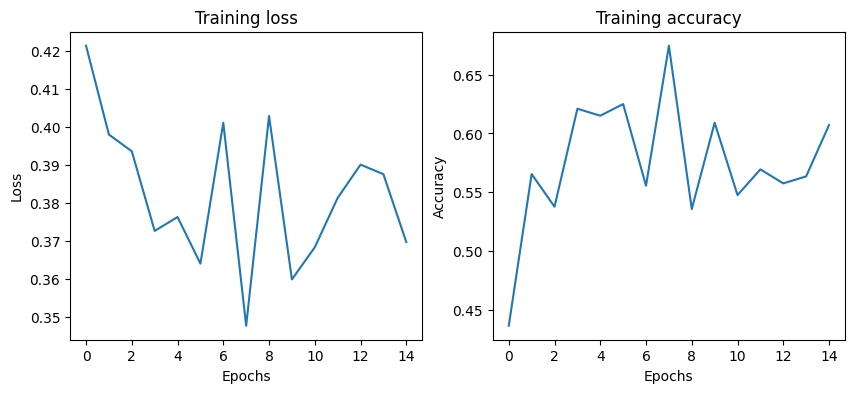

In [15]:
loss = history.history['loss']
accuracy = history.history['accuracy']

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axs[0].plot(range(len(loss)), loss)
axs[0].set(xlabel="Epochs", ylabel="Loss", title="Training loss")
axs[1].plot(range(len(accuracy)), accuracy)
axs[1].set(xlabel="Epochs", ylabel="Accuracy", title="Training accuracy")
plt.show()

In [16]:
score = model.evaluate(valid_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

347/347 [==============================] - 55s 157ms/step - loss: 0.7185 - accuracy: 0.5895
Validation loss: 0.7185378670692444
Validation accuracy: 0.5894660949707031


In [17]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [18]:
print(predicted_classes)

[0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [19]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [20]:
import sklearn.metrics as metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      benign       1.00      0.50      0.67        24
      malign       0.67      1.00      0.80        24

    accuracy                           0.75        48
   macro avg       0.83      0.75      0.73        48
weighted avg       0.83      0.75      0.73        48



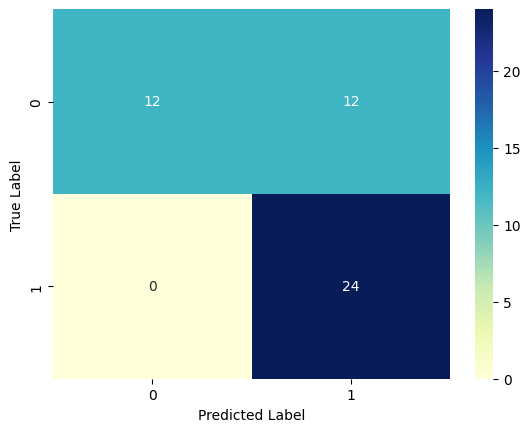

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image

In [23]:
def classify_image(inp):

  x = image.img_to_array(inp)
  x = np.expand_dims(x, axis=0)  
  datagen = ImageDataGenerator(rescale=1./255)
  x = datagen.standardize(x)  
  preds = model.predict(x)
  pred_label = np.argmax(preds, axis=1)  
  print(pred_label)
  if pred_label == 0:
    text = 'The mole seems to be benign'
  if pred_label == 1:
    text = 'The mole seems to be cancerous. It is advised to visit a doctor for a follow-up'
  return text

In [24]:
description = '''Moles can be linked to skin cancer. This is especially true if you have a family history of skin cancer linked to moles. In addition to limiting your exposure to sunlight and using sunscreens, examining yourself for moles can help with early detection of melanoma (the deadliest type of skin cancer) and treatment.'''

In [25]:
gr.Interface(fn=classify_image, 
                 inputs=gr.Image(shape=(256, 256)),
             outputs="text",
             live = True,
            title = 'SkinCare',
            description = description).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[1]


Traceback (most recent call last):
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\routes.py", line 343, in run_predict
    event_id=event_id,
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\blocks.py", line 1016, in process_api
    fn_index, inputs, iterator, request, event_id
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\blocks.py", line 834, in call_function
    fn, *processed_input, limiter=self.limiter
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\to_thread.py", line 29, in run_sync
    limiter=limiter)
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)
  File "C:\Users\nicyj\AppData\Local\Temp\ipykernel_21692\809273695.py", line 3

[0]
